In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc, DIRECT_ACC
from jdgsim.option_classes import SimulationConfig, SimulationParams, MNParams, PlummerParams, MN_POTENTIAL
from jdgsim.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration
from jdgsim.units import CodeUnits
from jdgsim.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from jdgsim.potentials import MyamotoNagai



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1_000, 
                          external_accelerations=(MN_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=10000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=0.010000000000000002, integrator=0, acceleration_scheme=0, batch_size=10000, double_map=False, external_accelerations=(2,))
SimulationParams(G=1, t_end=6.7070874092034565, Plummer_params=PlummerParams(a=0.1, Mtot=1.0), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=650.0, a=0.30000000000000004, b=0.03))


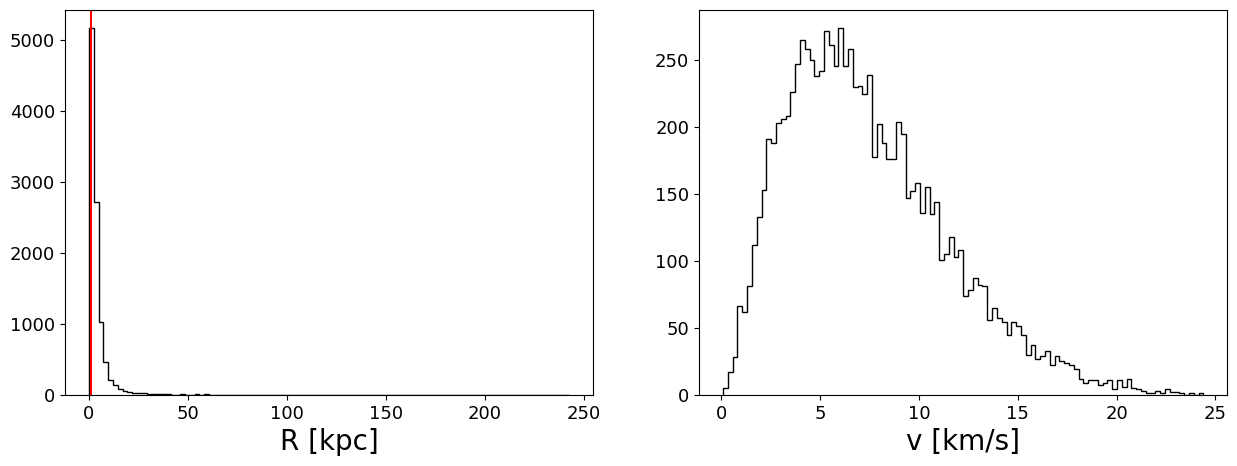

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
# radial distance of the center of mass
rp=100*u.kpc.to(code_units.code_length)

#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1  # Number of positions to generate
pos = sample_position_on_sphere(key, rp, num_samples)
vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
state_com = construct_initial_state(pos, vel)

# Calculate the acceleration at the center of mass
acc_com, _ = MyamotoNagai(state_com, config, params, return_potential=True)
#circular velocity at the center of mass
v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
inclination = jnp.radians(30)  # 30-degree inclination
#bulk motion to give to each particle of the Plummer sphere
vel = inclined_circular_velocity(pos, v_c, inclination)

print("Sampled Positions:\n", pos)
print("Corresponding Velocities:\n", vel)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos
velocities = velocities + vel
initial_state = construct_initial_state(positions, velocities)

Sampled Positions:
 [[0.78671551 8.71392177 4.84238022]]
Corresponding Velocities:
 [[-6.85192294  0.61860941  3.97204924]]


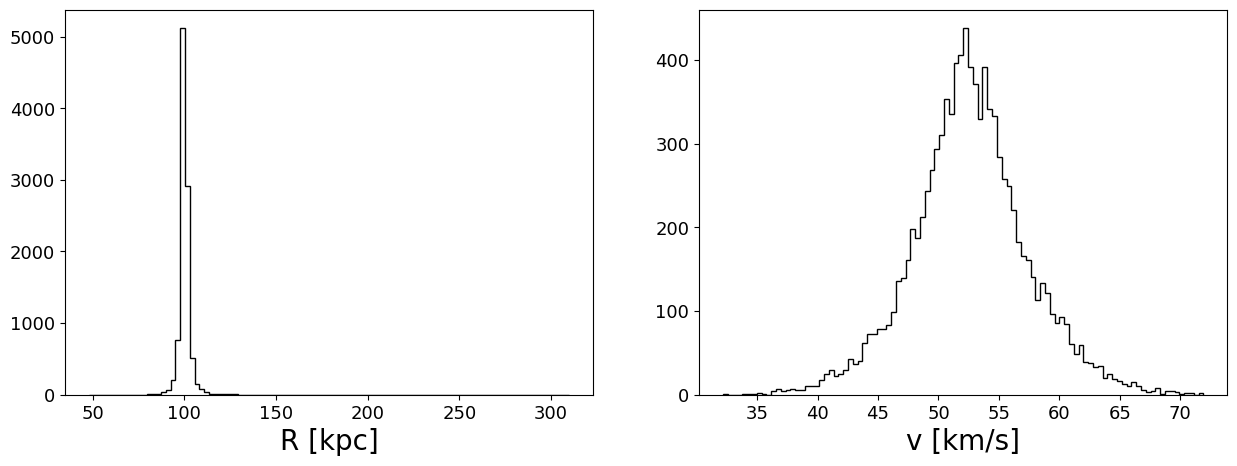

In [6]:
#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [7]:
if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state, mass, config, params))


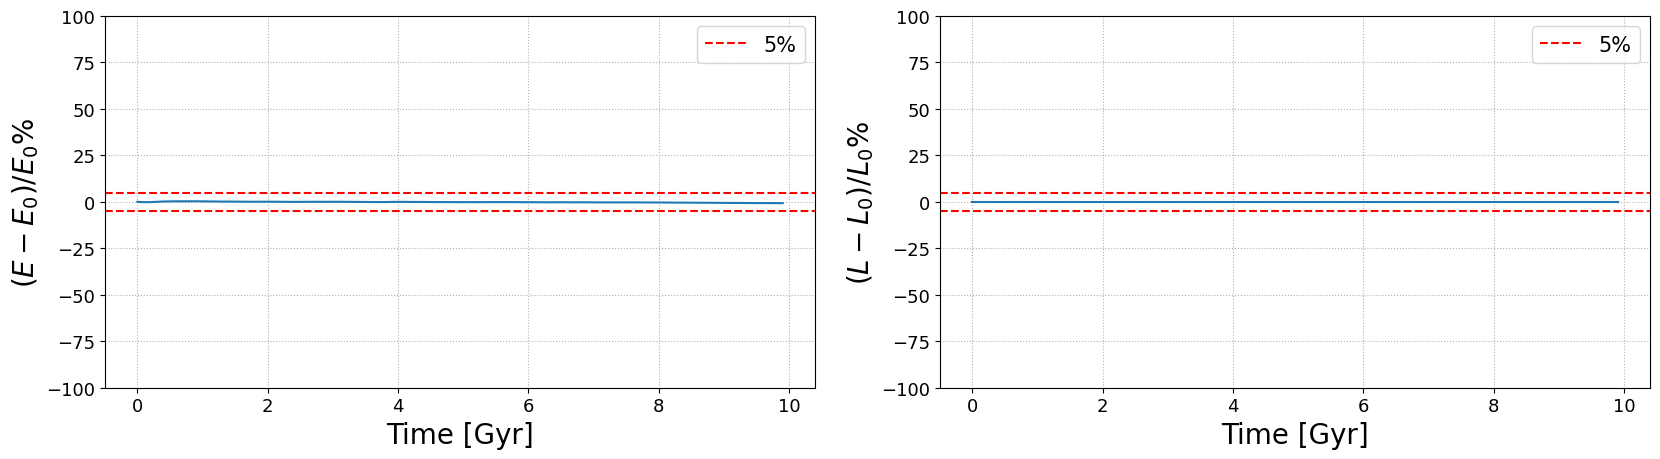

In [8]:
energy_angular_momentum_plot(snapshots, code_units, filename='./visualization/image/E_L_Plummer_in_MNpotential.pdf')

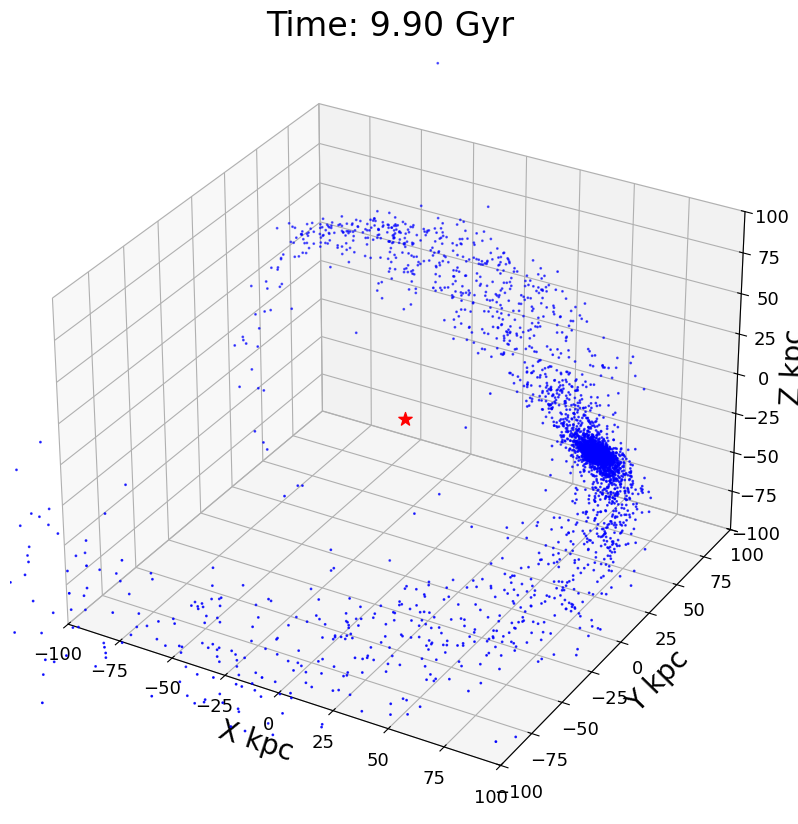

In [9]:
create_3d_gif(snapshots, 
              ax_lim=rp, 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
              filename='./visualization/gif/simulation_Plummer_in_MNpotential.gif')

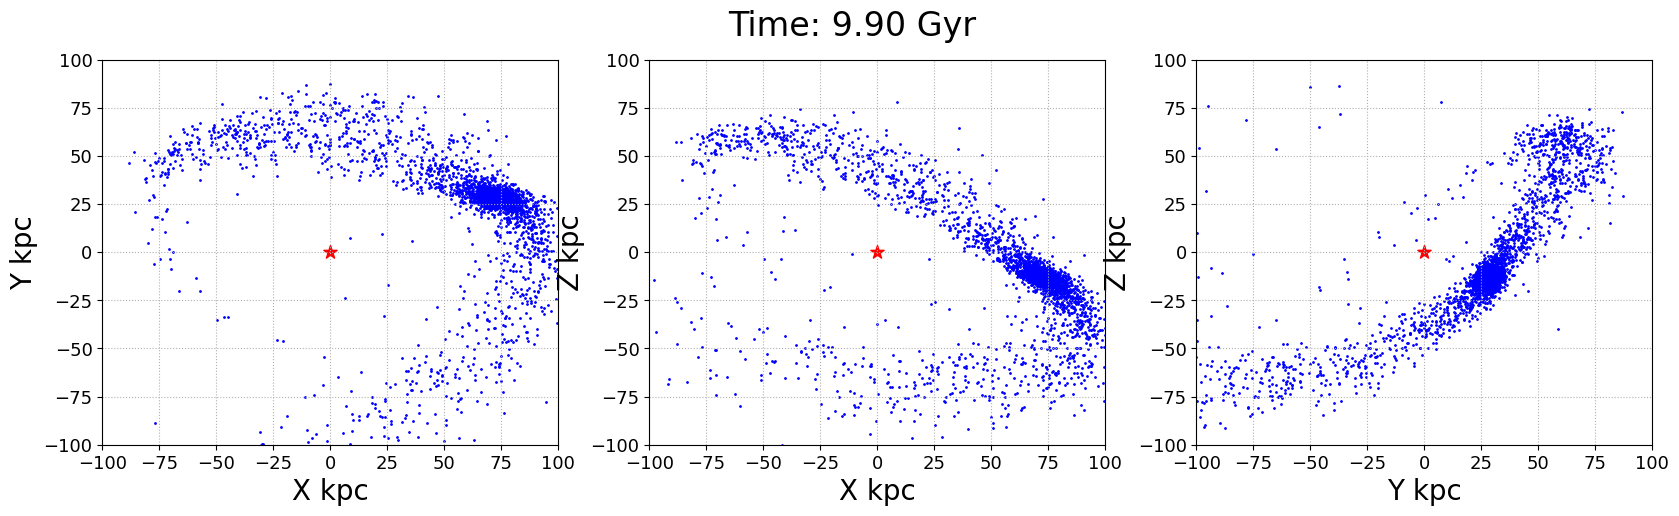

In [10]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=rp, 
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                      filename='./visualization/gif/simulation_projection_Plummer_in_MNpotential.gif')